In [99]:
import numpy as np
from datetime import datetime
from core.trade_service.traders.base import BaseTrader
from core.trade_service.instruments.moving_averages import MA


class MACD_Trader(BaseTrader):
    def __init__(self,
                 mode='test',
                 symbol='BTCUSDT',
                 interval_source='5m',
                 interval_group='1h',
                 on_investment: bool = False,
                 column_name: str = 'close',
                 period_short: int = 3,
                 period_long: int = 10,
                 period_signal: int = 5,
                 panic=-0.01,
                 start_time=datetime.fromisoformat('2020-01-01 00:00:00')
                 ):
        super().__init__(mode, symbol, interval_source, interval_group, start_time, on_investment)
        self.period_short = period_short
        self.period_long = period_long
        self.period_signal = period_signal
        self.column_name = column_name
        self.ma_short1: MA
        self.ma_short2: MA
        self.ma_long: MA
        self.restart()
        self.panic = panic

    def restart(self):
        return self
        
    def _calc_MACD(self, data):
        short = data.close.ewm(span=self.period_short, adjust=False).mean()
        long = data.close.ewm(span=self.period_long, adjust=False).mean()
        macd = short-long
        signal = macd.ewm(span=self.period_signal, adjust=False).mean()
        return macd, signal
    
    def evaluate_buy(self, data):
        if len(data) > self.period_long:
            macd, signal = self._calc_MACD(data)
            return macd[-1] > signal[-1]
        else:
            return False

    def evaluate_sell(self, data):
        if len(data) > self.period_long:
            macd, signal = self._calc_MACD(data)
            return macd[-1] < signal[-1]
        else:
            return False

    def get_params(self, deep=True):
        return {'mode': self.mode,
                'symbol': self.symbol,
                'interval_source': self.interval_source,
                'interval_group': self.interval_group,
                'on_investment': self.on_investment,
                'period_short': self.period_short,
                'period_long': self.period_long,
                'column_name': self.column_name,
                'panic': self.panic,
                'delta_buy': self.delta_buy,
                'delta_sell': self.delta_sell
                }


In [96]:
model = MACD_Trader(mode='sim', interval_source='1h', period_short=14, period_long=25, period_signal=9, panic=-0.03)

In [97]:
model.evaluate()

In [98]:
model.score(1,1)

31.184080948777083

In [8]:
from core.analitics.basic_plots import plot_timeline_month

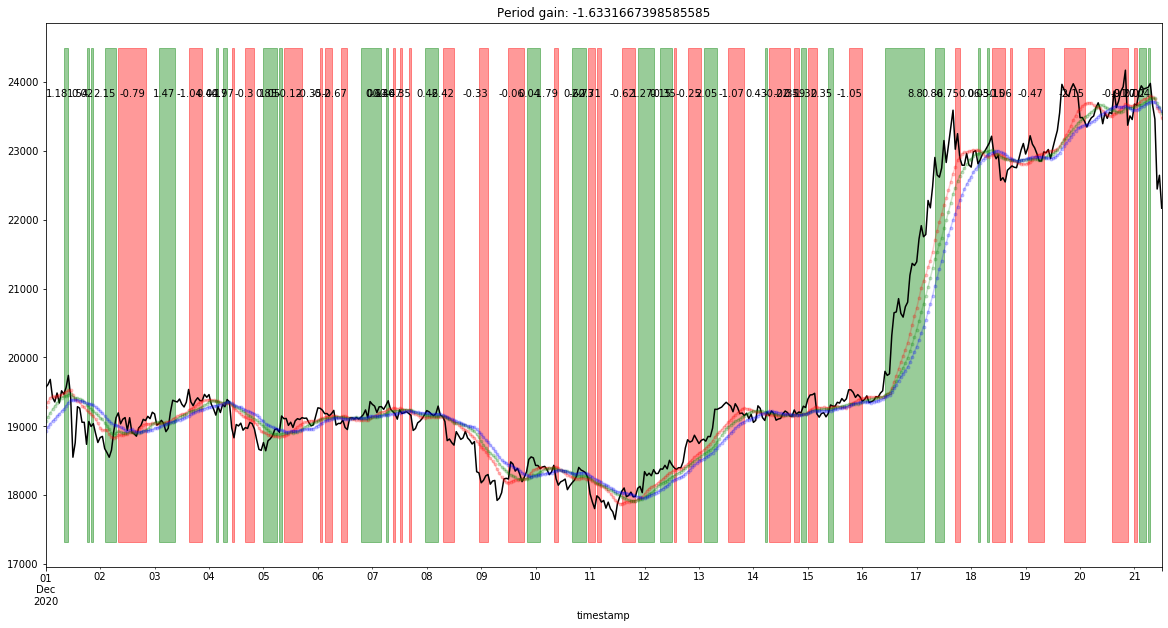

In [16]:
from core.analitics.basic_plots import to_pandas 
import matplotlib.pyplot as plt 
import matplotlib.pylab as pl

def plot_timeline_month(trader: BaseTrader, month: int):
    result_pd = to_pandas(trader)
    result_pd = result_pd[result_pd.start_datetime.dt.month == month]
    data = trader.data_mgr.get_data()
    data.loc[:, 'malong'] = trader.ma_long.evaluate(data)
    data.loc[:, 'mashort1'] = trader.ma_short1.evaluate(data)
    data.loc[:, 'mashort2'] = trader.ma_short2.evaluate(data)
    data = data[data.index.month == month]
    data.close.plot(figsize=(20, 10), color='black')
    data.mashort1.plot(marker='.', color='r', alpha=.2)
    data.mashort2.plot(marker='.', color='g', alpha=.2)
    algo = data.malong.plot(marker='.', color='b', alpha=.2)
    y_min, y_max = algo.get_ylim()
    for init, end, gain in zip(result_pd.start_datetime, result_pd.end_datetime, result_pd.gain):
        color = 'red' if gain < 0 else 'green'
        plt.fill_between(data[init:end].index, y_min, y_max, color=color, alpha=0.4)
        pl.text(end, y_min + (y_max - y_min) * 0.9, s=round(gain, 2), horizontalalignment='right')
        plt.title('Period gain: {}'.format(result_pd.gain.sum()))

plot_timeline_month(model, 12)

In [17]:
params = {'period_short': [0.001, 0.002, 0.003],
          'period_long': [-.001, -.002, -.003]
        }

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
gs = GridSearchCV(model, params, cv=2, verbose=10, n_jobs=2)

In [33]:
gs.fit(np.zeros([100,2]),np.ones(100))

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   31.6s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:  4.7min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=<__main__.DMA_Trader object at 0x7feb46223710>,
             iid='deprecated', n_jobs=2,
             param_grid={'delta_buy': [0.001, 0.002, 0.003],
                         'delta_sell': [-0.001, -0.002, -0.003]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [34]:
gs.best_score_

49.90147060594851

In [35]:
gs.best_params_

{'delta_buy': 0.001, 'delta_sell': -0.003}

In [36]:
!pip install hyperopt

     |████████████████████████████████| 965 kB 3.9 MB/s eta 0:00:01


In [102]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials
import hyperopt

In [106]:
space = {
    'period_short': hp.choice('period_short', list(range(5, 20))),
    'period_long': hp.choice('period_long', list(range(20, 40))),
    'period_signal': hp.choice('period_signal', list(range(5, 10)))
}

In [104]:
def objective(params):
    print(params)
    model = MACD_Trader(mode='sim',
                     interval_group='1h', 
                     interval_source='1h',
                     start_time=datetime.fromisoformat('2020-01-01'),
                     **params
                     )

    model.evaluate()

    return -model.score(1,1)

In [107]:
tpe_trials = Trials()

best = fmin(fn=objective,
            space=space,
            trials = tpe_trials,
            verbose=1,
            algo=hyperopt.tpe.suggest,
            return_argmin=False,
            max_evals=400)

{'period_long': 27, 'period_short': 6, 'period_signal': 8}
{'period_long': 33, 'period_short': 14, 'period_signal': 9}                        
{'period_long': 25, 'period_short': 10, 'period_signal': 7}                        
{'period_long': 24, 'period_short': 19, 'period_signal': 9}                       
{'period_long': 28, 'period_short': 16, 'period_signal': 5}                         
{'period_long': 23, 'period_short': 6, 'period_signal': 6}                          
{'period_long': 24, 'period_short': 13, 'period_signal': 5}                         
{'period_long': 31, 'period_short': 7, 'period_signal': 9}                          
{'period_long': 27, 'period_short': 18, 'period_signal': 7}                         
{'period_long': 20, 'period_short': 13, 'period_signal': 6}                         
{'period_long': 31, 'period_short': 8, 'period_signal': 5}                          
{'period_long': 31, 'period_short': 17, 'period_signal': 8}                         
{'period_l

## Auxiliar 

In [76]:
a = hp.choice('max_depth', list(np.arange(1, 31)))
b = hp.loguniform('learning_rate', -6, -.5)

In [77]:
from hyperopt.pyll.stochastic import sample

In [78]:
result=[]
for i in range(1000):
    result.append(sample(b))

In [79]:
import matplotlib.pyplot as plt

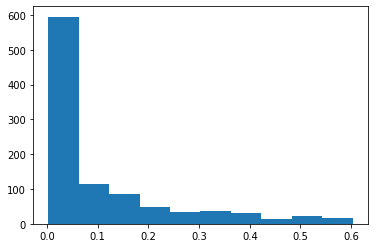

In [80]:
plt.hist(result); plt.show()